General Guidelines:
- Use small filters: 3x3, 5x5, 7x7
- Repetitive: Conv, Pool, Conv, Pool...
- Increase # feat. maps: 32, 64, 128, 128, ...

# Import Modules

In [79]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Helper Functions

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

#   print(cm)
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap,  aspect='auto')
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Grayscale Image

## Load Dataset

In [93]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / X_train.max(), X_test / X_test.max()        # max pixel value in this case is 255

class_num = len(set(y_train))
print(X_train.shape, y_train.shape, class_num)
print(X_test.shape)

# 60000 samples, 28x28 pixels, 10 classes

(60000, 28, 28) (60000,) 10
(10000, 28, 28)


In [94]:
# add third dimension (color) for Conv Network as it requires 3D input
X_train, X_test = np.expand_dims(X_train, -1), np.expand_dims(X_test, -1)
print(X_train.shape)
# color features = 1 type as images are in grayscale

(60000, 28, 28, 1)


## Train Model

In [95]:
X_train[0].shape

(28, 28, 1)

In [96]:
i = Input(shape=X_train[0].shape)    # shape of each sample

x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)     # 32 feature maps, 3x3 filter, stride/move filter 2 pixels every step (speed up)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)


x = Flatten()(x)        # convert image into  feature vectors
x = Dropout(0.2)(x)     # drop 20% info for regularization

x = Dense(512, activation='relu')(x)        # two dense layer for classification
x = Dropout(0.2)(x)
x = Dense(class_num, activation='softmax')(x)

model = Model(i, x)     # (input, output)

In [97]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2626

In [21]:
# compile & train model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 38s 4ms/step - loss: 0.5149 - accuracy: 0.8098 - val_loss: 0.3927 - val_accuracy: 0.8533
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3557 - accuracy: 0.8667 - val_loss: 0.3361 - val_accuracy: 0.8738
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3089 - accuracy: 0.8843 - val_loss: 0.3141 - val_accuracy: 0.8846
Epoch 4/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2736 - accuracy: 0.8955 - val_loss: 0.3095 - val_accuracy: 0.8864
Epoch 5/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2513 - accuracy: 0.9056 - val_loss: 0.2960 - val_accuracy: 0.8899
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2258 - accuracy: 0.9149 - val_loss: 0.3074 - val_accuracy: 0.8935
Epoch 7/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2108 - accuracy: 0.9213 - val_loss: 0.2937 - val_accuracy

## Evaluate

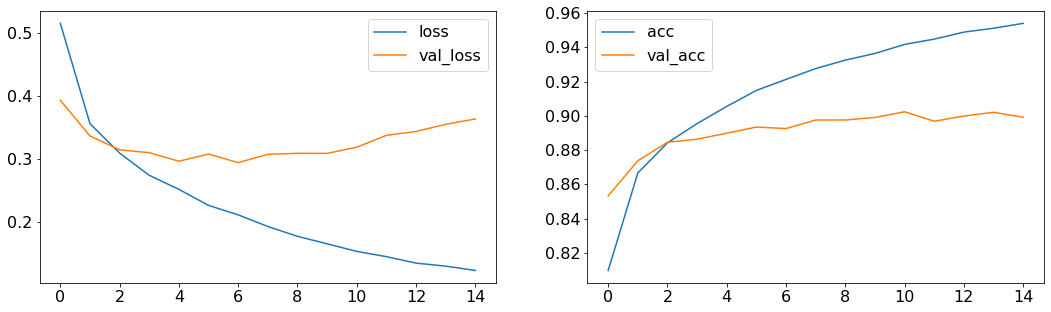

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), )
plt.rcParams['font.size'] = '16'

axes[0].plot(r.history['loss'], label='loss')
axes[0].plot(r.history['val_loss'], label='val_loss')
axes[0].legend(prop={"size":16})
# plt.show();

axes[1].plot(r.history['accuracy'], label='acc')
axes[1].plot(r.history['val_accuracy'], label='val_acc')
axes[1].legend(prop={"size":16})
plt.show();

# slightly over-trained at 6th epoch

Confusion matrix, without normalization


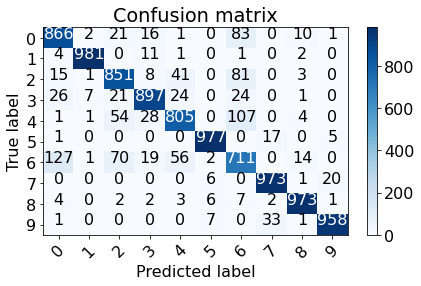

In [47]:
y_pred = model.predict(x_test).argmax(axis=1)   # argmax - return index with the highest value (among probabilities of each classes per sample)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(10)))

# of wrong label : (1008,)


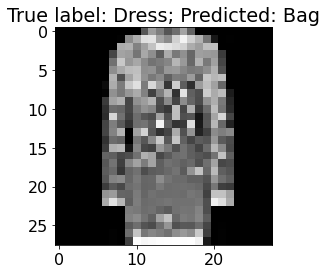

In [57]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
misclassified_idx = np.where(y_pred != y_test)[0]
print(f'# of wrong label : {misclassified_idx.shape}')

i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s; Predicted: %s" % (labels[y_test[i]], labels[y_pred[i]]));

# Color Image

## Load Dataset

In [58]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [65]:
X_train, X_test = X_train / X_train.max(), X_test / X_test.max()        # max pixel value in this case is 255
y_train, y_test = y_train.flatten(), y_test.flatten()                   # flatten array of arrays into an array

class_num = len(set(y_train))
print(X_train.shape, y_train.shape, class_num)
print(X_test.shape)

# 50000 samples, 32x32 pixels, 3 (RGB) color feature,  10 classes

(50000, 32, 32, 3) (50000,) 10
(10000, 32, 32, 3)


## Pre-Process - Data Augmentation

In [72]:
X_train.shape[0] // 32

1562

In [73]:
BATCH_NUM = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train, BATCH_NUM)
steps_per_epoch = X_train.shape[0] // BATCH_NUM        # // - Floor division

## Train Model

In [81]:
i = Input(shape=X_train[0].shape)

### Simpler Version ####
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)    # same padding to avoid too many image shrinking across Conv layers
x = BatchNormalization()(x)                                     # batch normalization - regularize & accelerate DNN via reudcing internal covariate shift
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)     # reduce image size by x2 width & height
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(class_num, activation='softmax')(x)

model = Model(i, x)

In [92]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        1849

In [83]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)

Epoch 1/50
1562/1562 [==============================] - 29s 18ms/step - loss: 1.4293 - accuracy: 0.4999 - val_loss: 1.2920 - val_accuracy: 0.5763
Epoch 2/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.9892 - accuracy: 0.6553 - val_loss: 1.0172 - val_accuracy: 0.6492
Epoch 3/50
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8431 - accuracy: 0.7092 - val_loss: 0.7358 - val_accuracy: 0.7490
Epoch 4/50
1562/1562 [==============================] - 27s 18ms/step - loss: 0.7531 - accuracy: 0.7435 - val_loss: 0.7984 - val_accuracy: 0.7363
Epoch 5/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.6822 - accuracy: 0.7660 - val_loss: 0.6685 - val_accuracy: 0.7756
Epoch 6/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.6314 - accuracy: 0.7865 - val_loss: 0.6099 - val_accuracy: 0.8004
Epoch 7/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.5894 - accuracy: 0.8020 - val_loss: 0.5602 -

## Evaluation

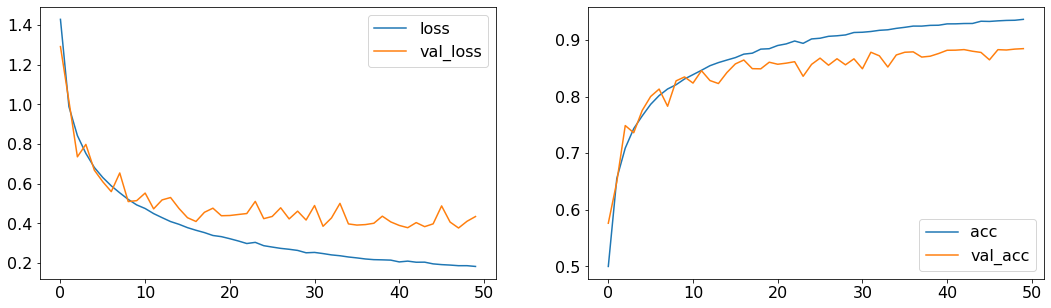

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), )
plt.rcParams['font.size'] = '16'

axes[0].plot(r.history['loss'], label='loss')
axes[0].plot(r.history['val_loss'], label='val_loss')
axes[0].legend(prop={"size":16})
# plt.show();

axes[1].plot(r.history['accuracy'], label='acc')
axes[1].plot(r.history['val_accuracy'], label='val_acc')
axes[1].legend(prop={"size":16})
plt.show();

Confusion matrix, without normalization


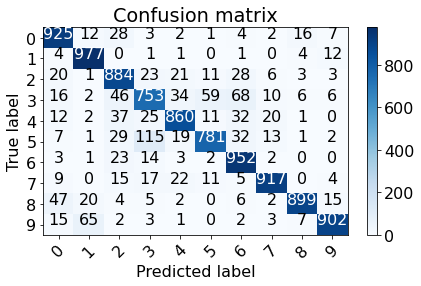

In [86]:
y_pred = model.predict(X_test).argmax(axis=1)   # argmax - return index with the highest value (among probabilities of each classes per sample)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(10)))

# of wrong label : (1150,)


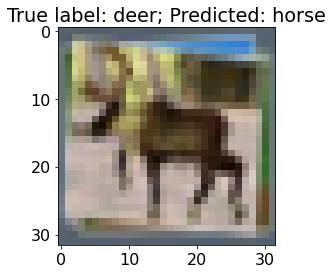

In [91]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
misclassified_idx = np.where(y_pred != y_test)[0]
print(f'# of wrong label : {misclassified_idx.shape}')

i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s; Predicted: %s" % (labels[y_test[i]], labels[y_pred[i]]));